In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import configparser
import pickle

In [2]:
# -- Functions

%run functions.ipynb

In [3]:
# -- Init Configuration Parameters

%run predict_notebook_sections/configuration.ipynb

Configuration file loaded: config-train_ticket.ini


In [4]:
# -- Load data sets configuration
data_sets_config = load_data_sets_config(data_sets_config_file_path)

In [5]:
# --- Setting data set failure types for visualization

data_sets= {
    "cpu-stress" : [
        "linear-cpu-stress-ts-station-service-020211",
        "linear-cpu-stress-ts-basic-service-020616",
        "linear-cpu-stress-ts-train-service-020713",
    ], 
    "memory-stress" : [
        "linear-memory-stress-ts-station-service-021917",
        "linear-memory-stress-ts-basic-service-022009",
        "linear-memory-stress-ts-train-service-021316",
        
    ], 
    "network-delay" : [
        "linear-network-delay-ts-station-service-013016",
        "linear-network-delay-ts-basic-service-020911",
        "linear-network-delay-ts-train-service-020116",
    ],
    "combined_cpu_memory" : [
        "linear-cpu-station-memory-train-020810",
    ],
    "combined_memory_cpu" : [
        "linear-cpu-train-memory-station-020912",
    ],
    "combined_cpu_delay" : [
        "linear-cpu-station-delay-train-021310",
    ],
    "combined_delay_cpu" : [
        "linear-cpu-train-delay-station-021212",
    ],
    "combined_memory_delay" : [
        "linear-memory-station-delay-train-022622",
    ],
    "combined_delay_memory" : [
        "linear-memory-train-delay-station-022621",
    ]
}

In [6]:
# --- Create the lists of the attacked and related services

attacked_services_by_data_set_code = {}
for idx, data_set_code in enumerate(prod_data_set_codes):
    attacked_services_by_data_set_code[data_set_code] = data_sets_config[data_set_code][3]
    
related_services_by_data_set_code = {}
for idx, data_set_code in enumerate(prod_data_set_codes):
    related_services_by_data_set_code[data_set_code] = data_sets_config[data_set_code][4].split(":")

In [7]:
print("Meta data")
print(" -------------------------------------------------------------------- ")
print("Each plot shows the prediction and localization results related to different types of failures")
print("Each line on the plots reflects the results on different data sets (depending on the service the failure was injected).")
print("Each line on the plots is annotated by the title containing the failure type, attacked and related services names. Format: ATTACKED SERVICE : RELATED SERVICES")
print("Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:")
print(
      " - Yellow: No prediction", "\n"
      " - Pink: False positive predition (prediction on the pediod before the failure injection) or the true positive prediciton (the prediction after the failure injection) with incorrect localization", "\n"
      " - Light blue: True positive prediciton with weak localization", "\n"
      " - Blue: True positive prediciton with strong localization", "\n"
      " - Red: System disruption", "\n"
     )
print("Vertical red line depicts the failure injection minute")
print(" -------------------------------------------------------------------- ")

Meta data
 -------------------------------------------------------------------- 
Each plot shows the prediction and localization results related to different types of failures
Each line on the plots reflects the results on different data sets (depending on the service the failure was injected).
Each line on the plots is annotated by the title containing the failure type, attacked and related services names. Format: ATTACKED SERVICE : RELATED SERVICES
Each cell has a specific color depending on the result of Predictions/Localization within the corresponding timestamp:
 - Yellow: No prediction 
 - Pink: False positive predition (prediction on the pediod before the failure injection) or the true positive prediciton (the prediction after the failure injection) with incorrect localization 
 - Light blue: True positive prediciton with weak localization 
 - Blue: True positive prediciton with strong localization 
 - Red: System disruption 

Vertical red line depicts the failure injection minu

cpu-stress
Data set code: linear-cpu-stress-ts-station-service-020211
cpu-stress ['ts-station'] false alarm rate: 23.333333333333332
cpu-stress ['ts-station'] miss alarm rate: 3.7037037037037037
cpu-stress ['ts-station'] false localization rate: 0.0
cpu-stress ['ts-station'] overall localization rate: 96.29629629629629
Check 100.0
Miss alarm 2
True localizations 52
False localizations 0
Data set code: linear-cpu-stress-ts-basic-service-020616
cpu-stress ['ts-basic'] false alarm rate: 13.333333333333334
cpu-stress ['ts-basic'] miss alarm rate: 5.504587155963303
cpu-stress ['ts-basic'] false localization rate: 0.9174311926605505
cpu-stress ['ts-basic'] overall localization rate: 93.57798165137615
Check 100.0
Miss alarm 6
True localizations 102
False localizations 1
Data set code: linear-cpu-stress-ts-train-service-020713
cpu-stress ['ts-train'] false alarm rate: 3.3333333333333335
cpu-stress ['ts-train'] miss alarm rate: 4.444444444444445
cpu-stress ['ts-train'] false localization rate: 

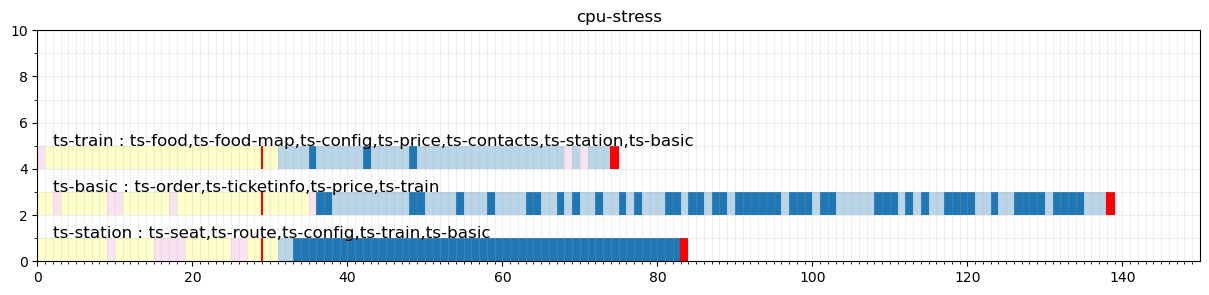

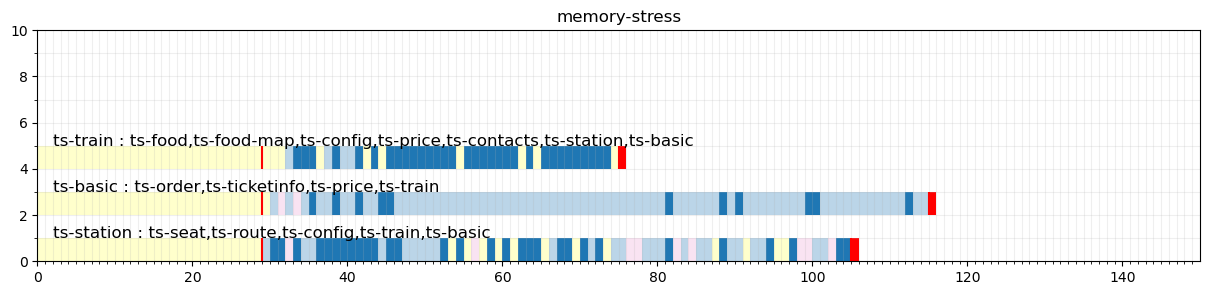

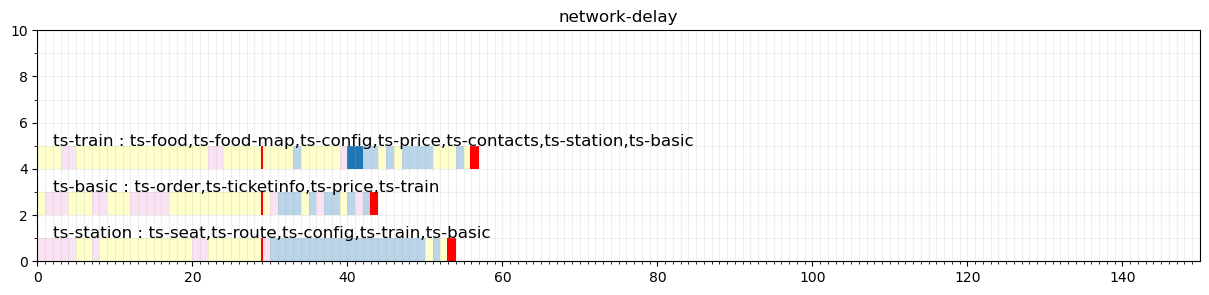

In [8]:
# -- Predictions/Localizations Visualisation

if use_re_sliding_window:
    localisations_file = localisations_by_reconstruction_error_sliding_window_file_path

fprs = {}
tprs_pred = {}
tprs_s_loc = {}
tprs_w_loc = {}
tprs_loc = {}
false_loc = {}

baseline_statistcis = []

for failure_type in data_sets:
    
    if "combined" in failure_type:
        continue
    
    print(failure_type)

    if failure_type == "network-delay":
        fig_h = 10
        fig_s = 3
    else:
        fig_h = 10
        fig_s = 3

    fig, ax = plt.subplots(figsize=(15, fig_s))
    ax.set_title(failure_type)
    ax.set_xlim([1, 150])
    ax.set_ylim([0, fig_h], auto=False)
    minor_ticks_x = np.arange(0, 150, 1)
    minor_ticks_y = np.arange(0, fig_h, 1)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='both', alpha=0.2)

    for data_set_code_idx, data_set_code in enumerate(data_sets[failure_type]):

        fp = 0
        tp_pred = 0    
        tp_s_loc = 0
        tp_w_loc = 0   
        tp_loc = 0

        print("Data set code:", data_set_code)
        
        attacked_services = [attacked_services_by_data_set_code[data_set_code]]
        # print("Attacked service:", attacked_services)
        related_services = related_services_by_data_set_code[data_set_code]
        # print("Related service:", related_services)

        # Load predictions
        with open(predictions_file_path.format(data_set_code=data_set_code), newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            predictions = [int(row[0]) for row in csv_reader]

        # Load localizations. 1 if the one of the faulty nodes is in top 1, 0 otherwise
        # Define Final localizations
        with open(localisations_file.format(data_set_code=data_set_code), "r") as file_in:
            csv_reader = csv.reader(file_in, delimiter=',')

            localizations = []
            for row_idx, row in enumerate(csv_reader):

                # top_list_1: the list that contains the top 1 rated services; 
                # top_list_rest: the list that contains the top 2,..,n rated services
                top_list_1, top_list_rest  = get_top_lists(row, NUMBER_TOP_RATED_SERVICES, GENERAL_SERVICES)

                # Get the localization type
                localization_type = get_localization_type(top_list_1, top_list_rest, attacked_services, related_services, 1, 2, 2, 2)

                localizations.append(localization_type)

        # Get the Failure injection and the System Disruption points
        fi_point = data_sets_config[data_set_code][1]
        fa_point = data_sets_config[data_set_code][2]

        # Get the Predictions and Localizations of the period from the start of the experiment to the system disruption point
        predictions = predictions[:fa_point - 1]
        localizations = localizations[:fa_point - 1]

        if "userapi" in data_set_code or "redis" in data_set_code:
            shift_plot = 0
        elif failure_type == "memory-stress":
            shift_plot = 90
        else:
            shift_plot = 30
        
        if data_set_code == "linear-memory-stress-userapi-051218":
            predictions = predictions[1 :]
            localizations = localizations[1 :]
            fi_point -= 1
            
        if data_set_code == "linear-network-delay-redis-092016":
            predictions = predictions[1 :]
            localizations = localizations[1 :]
            fi_point -= 1

        predictions = predictions[shift_plot:]
        localizations = localizations[shift_plot:]
        fi_point = fi_point - shift_plot
        fa_point = fa_point - shift_plot    

        # - Vizaulization (one plot per failure type)
        line_shift = data_set_code_idx * 2
        ax.vlines(fi_point - 1, line_shift + 1, line_shift, color="red")
        ax.vlines(fa_point - 1, line_shift + 1, line_shift, color="red")

        true_localizations = 0
        num_false_alarms = 0
        num_miss_alarms = 0
        false_localizations = 0
        
        
        if failure_type == 'memory-stress'and 'userapi' in attacked_services or failure_type == 'network-delay'and 'redis' in attacked_services:
            fa_point -= 1

        for time_point, prediction in enumerate(predictions):
            if time_point < fi_point - TIME_BEFORE_INJECTION:
                continue

            localization = localizations[time_point]

            if prediction == 1:
                # (False) prediction before failure injection
                if (time_point + 1) < fi_point:
                    ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
                    
                    fp += 1
                    num_false_alarms += 1
                else:
                    # Strong Localization
                    if localization == 1:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1)
                        
                        tp_pred += 1
                        tp_loc += 1
                        tp_s_loc += 1

                        true_localizations += 1

                    # Weak Localization
                    if localization == 2:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)
                        
                        tp_pred += 1
                        tp_loc += 1
                        tp_w_loc += 1

                        true_localizations += 1

                    # No Localization
                    if localization == 0:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
                        
                        tp_pred += 1
                        false_localizations += 1

                        if data_set_code == 'linear-memory-stress-ts-basic-service-020713':
                            print(time_point + 1)
            else:
                # No prediction
                ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)

                if (time_point + 1) >= fi_point:
                    num_miss_alarms += 1

        # - Add disruption point to the plot
        ax.broken_barh([(time_point + 1, 1)], (line_shift, 1.0), facecolors=('red'), alpha=1)
        
        # - Set title for each line
        # line_title = data_set_code.split("-")[-1] + " : " + failure_type + " : " + attacked_services[0]
        line_title = attacked_services[0]
        if attacked_services[0] not in related_services:
            line_title = line_title + " : " + ','.join(related_services)
        ax.text(2, line_shift + 1, line_title, fontsize=12, color='black')


        # - Compute statistics [Start]

        false_alarm_rate = 100 * num_false_alarms / 30
        print(f"{failure_type} {attacked_services} false alarm rate: {false_alarm_rate}")

        miss_alarm_rate = 100 * num_miss_alarms / (fa_point - fi_point)
        print(f"{failure_type} {attacked_services} miss alarm rate: {miss_alarm_rate}")

        false_localization_rate = 100 * false_localizations / (fa_point - fi_point)
        print(f"{failure_type} {attacked_services} false localization rate: {false_localization_rate}")

        overall_localization_rate = 100 * true_localizations / (fa_point - fi_point)
        print(f"{failure_type} {attacked_services} overall localization rate: {overall_localization_rate}")

        print("Check", miss_alarm_rate + false_localization_rate + overall_localization_rate)
        print("Miss alarm", num_miss_alarms)
        print("True localizations", true_localizations)
        print("False localizations", false_localizations)

        baseline_statistcis.append(
            (
                failure_type,
                attacked_services[0],
                false_alarm_rate,
                miss_alarm_rate,
                false_localization_rate,
                overall_localization_rate,
            )
        )

        # - Compute statistics [End]
    
        
        # - Compute total statistics [Start]

        fprs[data_set_code] = fp / TIME_BEFORE_INJECTION
        tprs_pred[data_set_code] = tp_pred / (fa_point - fi_point)
        tprs_s_loc[data_set_code] = tp_s_loc / (fa_point - fi_point)
        tprs_w_loc[data_set_code] = tp_w_loc / (fa_point - fi_point)
        tprs_loc[data_set_code] = tp_loc / (fa_point - fi_point)

        # - Compute total statistics [End]

        # variables_to_save = {'predictions': predictions, 'localizations': localizations}
        # with open(data_set_code+ '.pkl', 'wb') as f:
        #     pickle.dump(variables_to_save, f)

    # Save
    # with open(failure_type+'_fig.pkl', 'wb') as f:
    #     pickle.dump(fig, f)

print('Rate')
print('---')
for key, values in zip(fprs.keys(), zip(fprs.values(), tprs_pred.values(), tprs_s_loc.values(), tprs_w_loc.values(), tprs_loc.values())):
    print("Key:", key, "Values:", values)

# Save statistics
df_baseline_statistcis = pd.DataFrame(
    baseline_statistcis,
    columns=[
        "failure_type",
        "attacked_service",
        "false_alarm_rate",
        "miss_alarm_rate",
        "false_localization_rate",
        "overall_localization_rate",
    ],
)
df_baseline_statistcis.to_csv("Preface_statistics.csv", index=False)



Failure type: combined_cpu_memory  ::  Data set code: linear-cpu-station-memory-train-020810  :::  Attacked services: ['ts-station'] Related services: ['ts-train']

60 : ts-station ts-train 0 ['ts-execute', 'ts-route', 'ts-user'] 0 0 0 0 0 0
61 : ts-station ts-train 0 ['ts-order', 'ts-admin-order', 'ts-assurance'] 0 0 0 0 0 0
62 : ts-station ts-train 1 ['ts-station', 'ts-seat', 'ts-food'] 1 0 0 1 0 0
63 : ts-station ts-train 1 ['ts-station', 'ts-travel', 'ts-train'] 1 0 1 0 0 0
64 : ts-station ts-train 1 ['ts-admin-order', 'ts-station', 'ts-food-map'] 0 0 0 0 1 0
65 : ts-station ts-train 1 ['ts-consign', 'ts-train', 'ts-food-map'] 0 0 0 0 0 0
66 : ts-station ts-train 1 ['ts-train', 'ts-seat', 'ts-contacts'] 0 0 0 0 0 0
67 : ts-station ts-train 1 ['ts-train', 'ts-station', 'ts-food-map'] 0 0 0 0 0 0
68 : ts-station ts-train 1 ['ts-station', 'ts-train', 'ts-inside-payment'] 1 1 0 0 0 0
69 : ts-station ts-train 1 ['ts-station', 'ts-train', 'ts-user'] 1 1 0 0 0 0
70 : ts-station ts-train

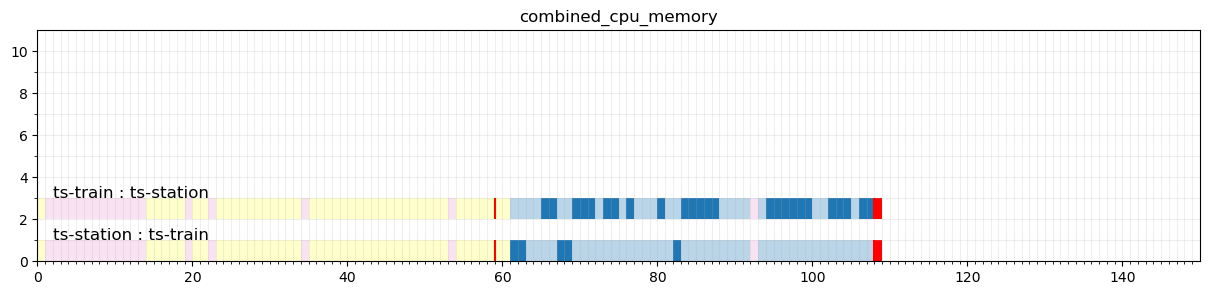

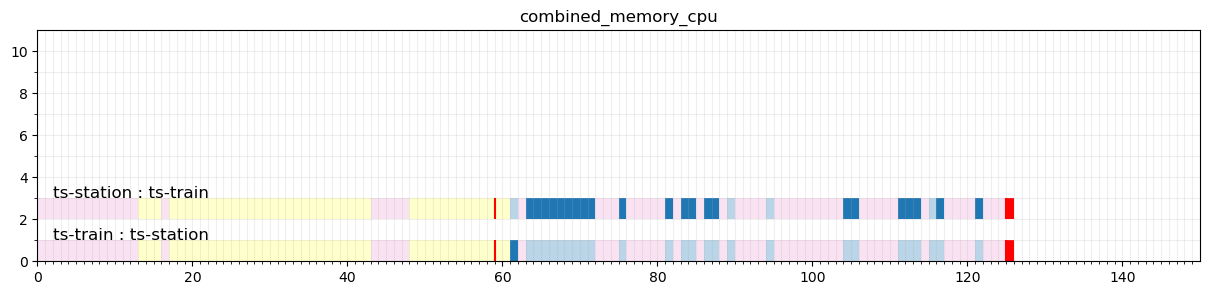

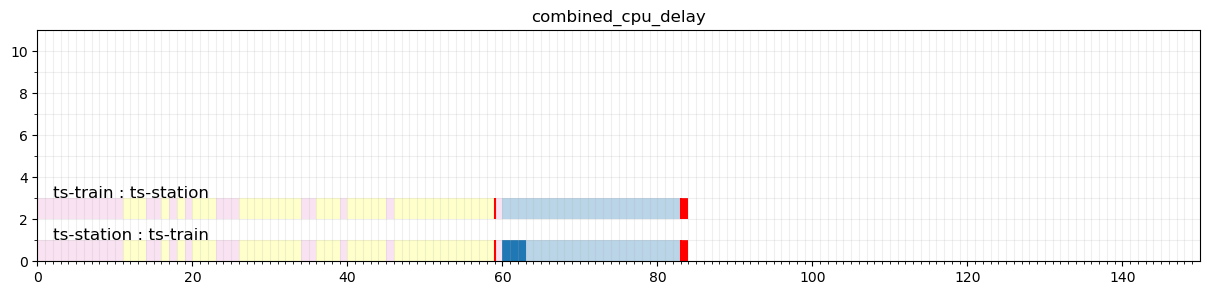

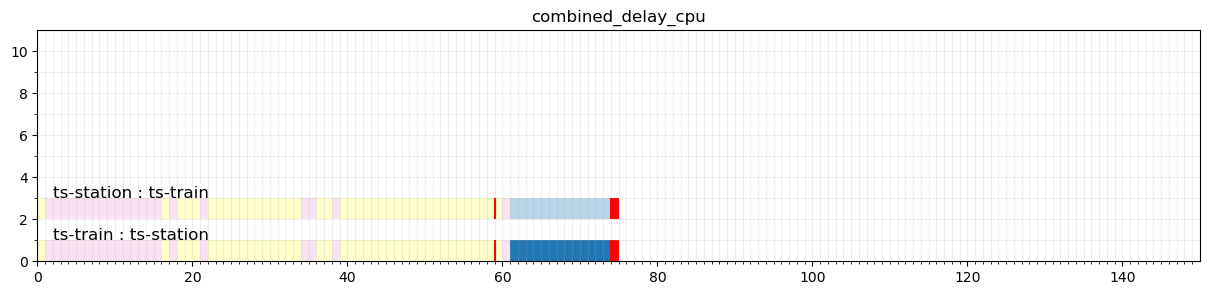

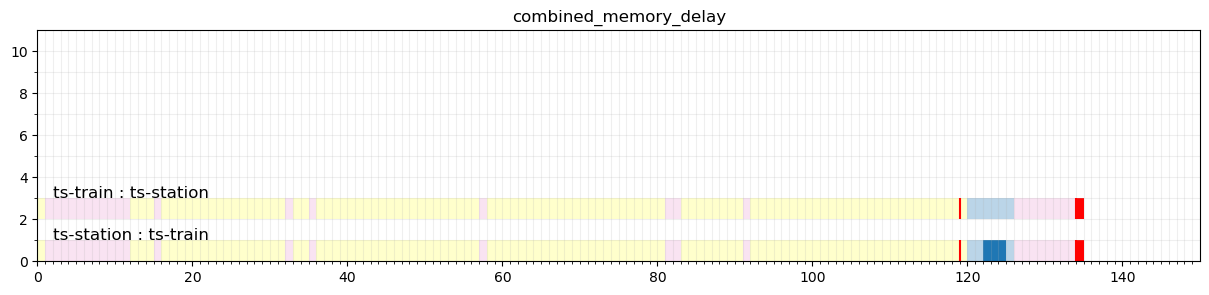

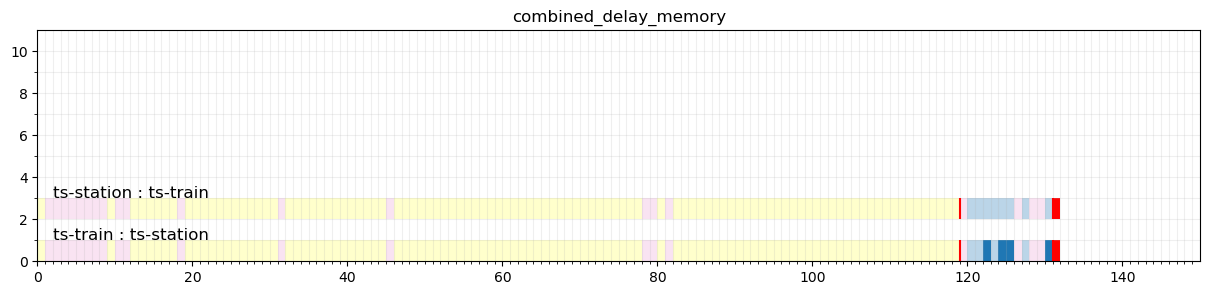

In [9]:
# -- Predictions/Localizations Visualisation (Combined injections)

if use_re_sliding_window:
    localisations_file = localisations_by_reconstruction_error_sliding_window_file_path

tprs_serviceA_top1 = {}
tprs_serviceA_top1_serviceB_top2 = {}
tprs_serviceA_top1_serviceB_top3 = {}
tprs_serviceA_top1_serviceB_out = {}
tprs_serviceA_top2_3_serviceB_out = {}
tprs_serviceA_top2_3_serviceB_top2_3 = {}

for failure_type in data_sets:
    
    if "combined" not in failure_type:
        continue

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.set_title(failure_type)
    ax.set_xlim([1, 150])
    ax.set_ylim([0, 11], auto=False)
    minor_ticks_x = np.arange(0, 150, 1)
    minor_ticks_y = np.arange(0, 11, 1)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='both', alpha=0.2)

    for data_set_code_idx, data_set_code in enumerate(data_sets[failure_type]):

        attacked_services = [attacked_services_by_data_set_code[data_set_code]]
        related_services = related_services_by_data_set_code[data_set_code]

        print()
        print()
        print("Failure type:", failure_type, " :: ", "Data set code:", data_set_code, " ::: ", "Attacked services:", attacked_services, "Related services:", related_services)
        print()

        for ver in range(2):

            if ver == 1:
                tmp =  related_services
                related_services = attacked_services
                attacked_services = tmp

            # Load predictions
            with open(predictions_file_path.format(data_set_code=data_set_code), newline='') as csvfile:
                csv_reader = csv.reader(csvfile)
                predictions = [int(row[0]) for row in csv_reader]

            # Get the Failure injection and the System Disruption points
            fi_point = data_sets_config[data_set_code][1]
            fa_point = data_sets_config[data_set_code][2]

            # Load localizations. 1 if the one of the faulty nodes is in top 1, 0 otherwise
            # Define Final localizations
            top_lists = []
            with open(localisations_file.format(data_set_code=data_set_code), "r") as file_in:
                csv_reader = csv.reader(file_in, delimiter=',')
                localizations = []
                for row_idx, row in enumerate(csv_reader):
                    # top_list_1: the list that contains the top 1 rated services; 
                    # top_list_rest: the list that contains the top 2,..,n rated services
                    top_list_1, top_list_rest  = get_top_lists(row, NUMBER_TOP_RATED_SERVICES, GENERAL_SERVICES)
                    top_lists.append(top_list_1 + top_list_rest)

                    # Get the localization type
                    localization_type = get_localization_type(top_list_1, top_list_rest, attacked_services, related_services, 1, 2, 2, 2)
                    localizations.append(localization_type)

            # - Calculate the statistics [START]

            tp_serviceA_top1 = 0
            tp_serviceA_top1_serviceB_top2 = 0
            tp_serviceA_top1_serviceB_top3 = 0
            tp_serviceA_top1_serviceB_out = 0
            tp_serviceA_top2_3_serviceB_out = 0
            tp_serviceA_top2_3_serviceB_top2_3 = 0

            for row_idx, prediction in enumerate(predictions):
                if fi_point <= row_idx + 1 < fa_point:

                    temp_1, temp_2, temp_3, temp_4, temp_5, temp_6 = get_tp(attacked_services[0], related_services[0], predictions[row_idx], top_lists[row_idx])
                    print(row_idx + 1, ":", attacked_services[0], related_services[0], predictions[row_idx], top_lists[row_idx], temp_1, temp_2, temp_3, temp_4, temp_5, temp_6)

                    tp_serviceA_top1 = tp_serviceA_top1 + temp_1
                    tp_serviceA_top1_serviceB_top2 = tp_serviceA_top1_serviceB_top2 + temp_2
                    tp_serviceA_top1_serviceB_top3 = tp_serviceA_top1_serviceB_top3 + temp_3
                    tp_serviceA_top1_serviceB_out = tp_serviceA_top1_serviceB_out + temp_4
                    tp_serviceA_top2_3_serviceB_out = tp_serviceA_top2_3_serviceB_out +temp_5
                    tp_serviceA_top2_3_serviceB_top2_3 = tp_serviceA_top2_3_serviceB_top2_3 +temp_6

            tprs_serviceA_top1[data_set_code + "_" + str(ver)] = round(tp_serviceA_top1 / (fa_point - fi_point), 2)
            tprs_serviceA_top1_serviceB_top2[data_set_code + "_" + str(ver)] = round(tp_serviceA_top1_serviceB_top2 / (fa_point - fi_point), 2)
            tprs_serviceA_top1_serviceB_top3[data_set_code + "_" + str(ver)] = round(tp_serviceA_top1_serviceB_top3 / (fa_point - fi_point), 2)
            tprs_serviceA_top1_serviceB_out[data_set_code + "_" + str(ver)] = round(tp_serviceA_top1_serviceB_out / (fa_point - fi_point), 2)
            tprs_serviceA_top2_3_serviceB_out[data_set_code + "_" + str(ver)] = round(tp_serviceA_top2_3_serviceB_out / (fa_point - fi_point), 2)
            tprs_serviceA_top2_3_serviceB_top2_3[data_set_code + "_" + str(ver)] = round(tp_serviceA_top2_3_serviceB_top2_3 / (fa_point - fi_point), 2)

            print()
            print("TP statistics:")
            print("Service A - TOP 1:    ", tp_serviceA_top1)
            print("Service A - TOP 1, Service B - TOP 2:    ", tp_serviceA_top1_serviceB_top2)
            print("Service A - TOP 1, Service B - TOP 3:    ", tp_serviceA_top1_serviceB_top3)
            print("Service A - TOP 1, Service B - OUT OF TOP:    ", tp_serviceA_top1_serviceB_out)
            print("Service A - TOP 2 or TOP 3, Service B - OUT OF TOP:    ", tp_serviceA_top2_3_serviceB_out)
            print("Service A - TOP 2 or TOP 3, Service B - TOP 2 or TOP 3:    ", tp_serviceA_top2_3_serviceB_top2_3)

            print()
            print("Duration of the failure injection period:", fa_point - fi_point)
            
            print()
            print("TPR statistics:")
            print("Service A - TOP 1:    ", tprs_serviceA_top1[data_set_code + "_" + str(ver)])
            print("Service A - TOP 1, Service B - TOP 2:    ", tprs_serviceA_top1_serviceB_top2[data_set_code + "_" + str(ver)])
            print("Service A - TOP 1, Service B - TOP 3:    ", tprs_serviceA_top1_serviceB_top3[data_set_code + "_" + str(ver)])
            print("Service A - TOP 1, Service B - OUT OF TOP:    ", tprs_serviceA_top1_serviceB_out[data_set_code + "_" + str(ver)])
            print("Service A - TOP 2 or TOP 3, Service B - OUT OF TOP:    ", tprs_serviceA_top2_3_serviceB_out[data_set_code + "_" + str(ver)])
            print("Service A - TOP 2 or TOP 3, Service B - TOP 2 or TOP 3:    ", tprs_serviceA_top2_3_serviceB_top2_3[data_set_code + "_" + str(ver)])
            print()

            # - Calculate the statistics [END]

            
            # Get the Predictions and Localizations of the period from the start of the experiment to the system disruption point
            predictions = predictions[:fa_point - 1]    
            localizations = localizations[:fa_point - 1]


            # - Vizaulization (one plot per failure type

            line_shift = ver * 2

            ax.vlines(fi_point - 1, line_shift + 1, line_shift, color="red")
            ax.vlines(fa_point - 1, line_shift + 1, line_shift, color="red")

            for time_point, prediction in enumerate(predictions):
                localization = localizations[time_point]

                if prediction == 1:
                    if (time_point + 1) < fi_point:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
                    else:
                        if localization == 0:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)

                        if localization == 1:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1) 

                        if localization == 2:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)

                        if localization == 3:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)

                        if localization == 4:
                            ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)
                else:
                    ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)

            ax.broken_barh([(time_point + 1, 1)], (line_shift, 1.0), facecolors=('red'), alpha=1)

            # - Set title for each line
            line_title = attacked_services[0]
            if attacked_services[0] not in related_services:
                line_title = line_title + " : " + ','.join(related_services)
            ax.text(2, line_shift + 1, line_title, fontsize=12, color='black')

print(' --- Localiation Statistics --- ', "\n")
for key, values in zip(tprs_serviceA_top1.keys(), zip(tprs_serviceA_top1.values(), tprs_serviceA_top1_serviceB_top2.values(), tprs_serviceA_top1_serviceB_top3.values(), tprs_serviceA_top1_serviceB_out.values(), tprs_serviceA_top2_3_serviceB_out.values(), tprs_serviceA_top2_3_serviceB_top2_3.values())):
    print("Key:", key, "Values:", values)

Failure type: combined_cpu_memory
Data set code: linear-cpu-station-memory-train-020810
Attacked service: ['ts-station']
Related service: ['ts-train']
Failure type: combined_memory_cpu
Data set code: linear-cpu-train-memory-station-020912
Attacked service: ['ts-train']
Related service: ['ts-station']
Failure type: combined_cpu_delay
Data set code: linear-cpu-station-delay-train-021310
Attacked service: ['ts-station']
Related service: ['ts-train']
Failure type: combined_delay_cpu
Data set code: linear-cpu-train-delay-station-021212
Attacked service: ['ts-train']
Related service: ['ts-station']
Failure type: combined_memory_delay
Data set code: linear-memory-station-delay-train-022622
Attacked service: ['ts-station']
Related service: ['ts-train']
Failure type: combined_delay_memory
Data set code: linear-memory-train-delay-station-022621
Attacked service: ['ts-train']
Related service: ['ts-station']
Rate
---
Key: linear-cpu-station-memory-train-020810 Values: (0.06666666666666667, 0.95918

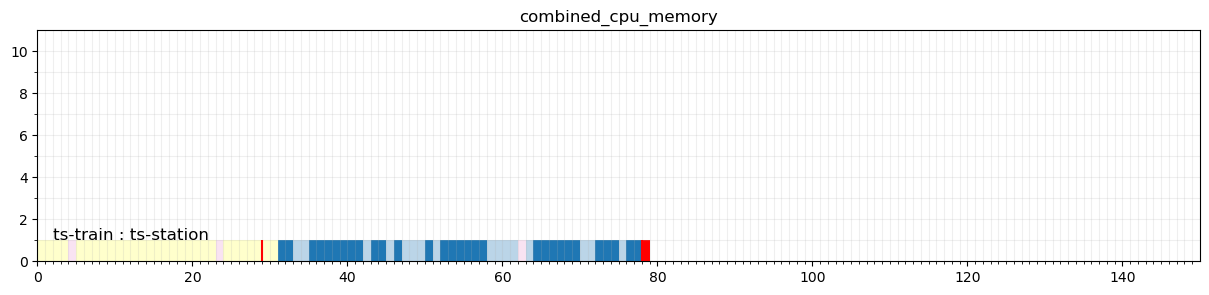

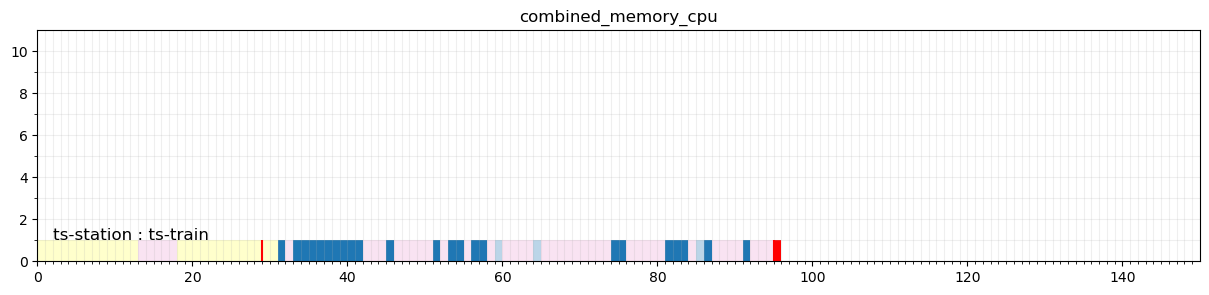

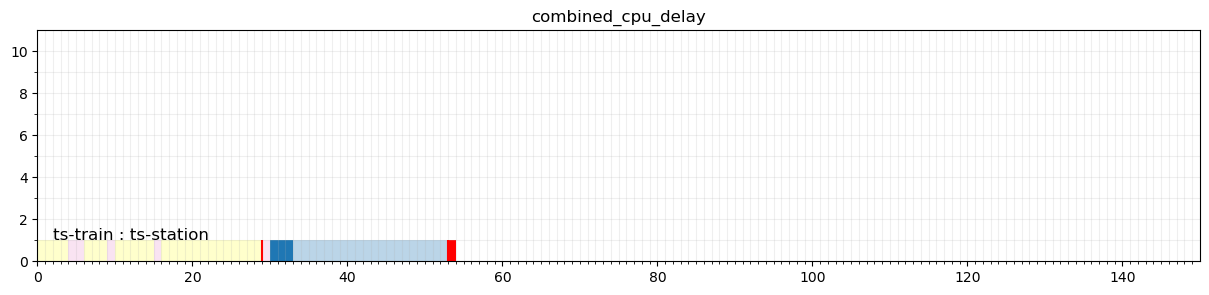

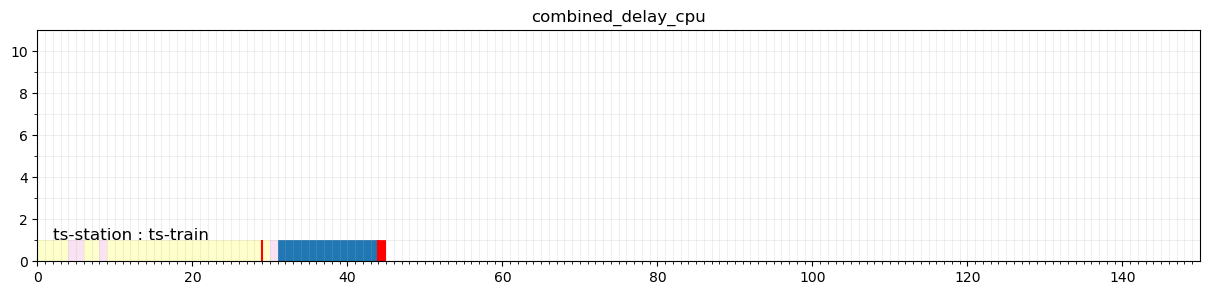

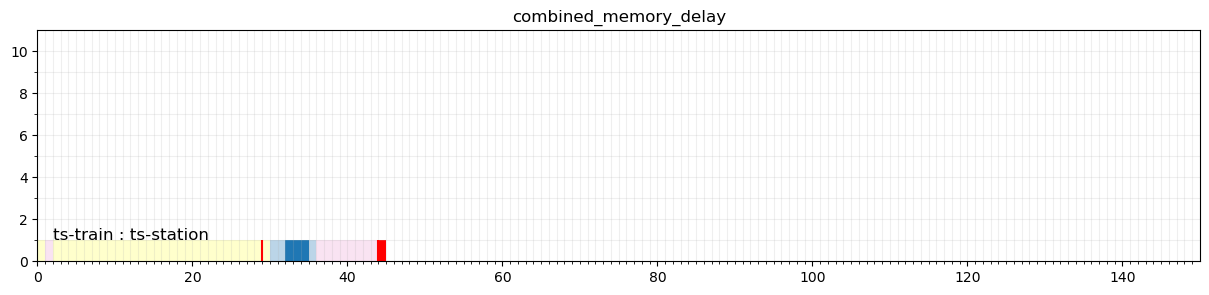

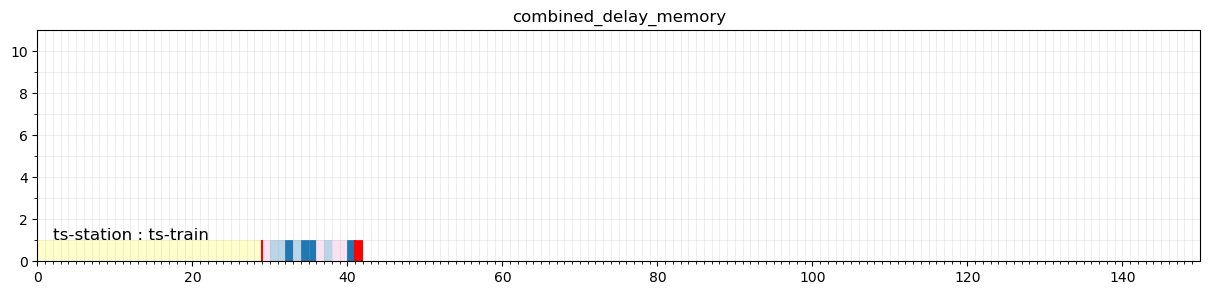

In [10]:
# -- Predictions/Localizations Visualisation (Combined injections)

if use_re_sliding_window:
    localisations_file = localisations_by_reconstruction_error_sliding_window_file_path

fprs = {}
tprs_pred = {}
tprs_s_loc = {}
tprs_w_loc = {}
tprs_loc = {}

for failure_type in data_sets:
    
    if "combined" not in failure_type:
        continue
    
    print('Failure type:', failure_type)

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.set_title(failure_type)
    ax.set_xlim([1, 150])
    ax.set_ylim([0, 11], auto=False)
    minor_ticks_x = np.arange(0, 150, 1)
    minor_ticks_y = np.arange(0, 11, 1)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='both', alpha=0.2)

    for data_set_code_idx, data_set_code in enumerate(data_sets[failure_type]):

        fp = 0
        tp_pred = 0    
        tp_s_loc = 0
        tp_w_loc = 0   
        tp_loc = 0
        
        print("Data set code:", data_set_code)

        attacked_services = [attacked_services_by_data_set_code[data_set_code]]
        print("Attacked service:", attacked_services)
        
        related_services = related_services_by_data_set_code[data_set_code]
        print("Related service:", related_services)
        
        # Load predictions
        with open(predictions_file_path.format(data_set_code=data_set_code), newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            predictions = [int(row[0]) for row in csv_reader]
            
        localizations = [[], []]

        for ver in range(2):
            
            if ver == 1:
                tmp =  related_services
                related_services = attacked_services
                attacked_services = tmp

            # Load localizations. 1 if the one of the faulty nodes is in top 1, 0 otherwise
            # Define Final localizations
            with open(localisations_file.format(data_set_code=data_set_code), "r") as file_in:
                csv_reader = csv.reader(file_in, delimiter=',')
                for row_idx, row in enumerate(csv_reader):

                    # top_list_1: the list that contains the top 1 rated services; 
                    # top_list_rest: the list that contains the top 2,..,n rated services
                    top_list_1, top_list_rest  = get_top_lists(row, NUMBER_TOP_RATED_SERVICES, GENERAL_SERVICES)

                    # Get the localization type
                    localization_type = get_localization_type(top_list_1, top_list_rest, attacked_services, related_services, 1, 2, 2, 2)

                    localizations[ver].append(localization_type)

        
        localizations = get_combo_localizations(localizations)

        # Get the Failure injection and the System Disruption points
        fi_point = data_sets_config[data_set_code][1]
        fa_point = data_sets_config[data_set_code][2]

        # Get the Predictions and Localizations of the period from the start of the experiment to the system disruption point
        predictions = predictions[:fa_point - 1]
        localizations = localizations[:fa_point - 1]

        if failure_type == 'combined_memory_delay' or failure_type == 'combined_delay_memory':
            shift_plot = 90
        else:
            shift_plot = 30

        predictions = predictions[shift_plot:]
        localizations = localizations[shift_plot:]
        fi_point = fi_point - shift_plot
        fa_point = fa_point - shift_plot

        # - Vizaulization (one plot per failure type

        line_shift = 0

        ax.vlines(fi_point - 1, line_shift + 1, line_shift, color="red")
        ax.vlines(fa_point - 1, line_shift + 1, line_shift, color="red")

        for time_point, prediction in enumerate(predictions):
            localization = localizations[time_point]

            if prediction == 1:
                # (False) prediction before failure injection
                if (time_point + 1) < fi_point:
                    ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)
                    
                    if (fi_point - time_point +1) <= TIME_BEFORE_INJECTION:
                        fp +=1

                else:
                    # No Localization
                    if localization == 0:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:pink'), alpha=0.2)

                        tp_pred += 1
                    # Weak Localization
                    if localization == 2:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=0.3)

                        tp_pred += 1
                        tp_loc += 1
                        tp_w_loc += 1
                    # Strong Localization
                    if localization == 1:
                        ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('tab:blue'), alpha=1)

                        tp_pred += 1
                        tp_loc += 1
                        tp_s_loc += 1
            else:
                ax.broken_barh([(time_point, 1)], (line_shift, 1.0), facecolors=('yellow'), alpha=0.2)

        # - Set title for each line
        line_title = attacked_services[0]
        if attacked_services[0] not in related_services:
            line_title = line_title + " : " + ','.join(related_services)
        ax.text(2, line_shift + 1, line_title, fontsize=12, color='black')

        fprs[data_set_code] = fp / TIME_BEFORE_INJECTION
        tprs_pred[data_set_code] = tp_pred / (fa_point - fi_point)
        tprs_s_loc[data_set_code] = tp_s_loc / (fa_point - fi_point)
        tprs_w_loc[data_set_code] = tp_w_loc / (fa_point - fi_point)
        tprs_loc[data_set_code] = tp_loc / (fa_point - fi_point)

        ax.broken_barh([(time_point + 1, 1)], (line_shift, 1.0), facecolors=('red'), alpha=1)

print('Rate')
print('---')
# for values in zip(fprs.values(), tprs_pred.values(), tprs_loc.values()):
#     print(key, values)
for key, values in zip(fprs.keys(), zip(fprs.values(), tprs_pred.values(), tprs_s_loc.values(), tprs_w_loc.values(), tprs_loc.values())):
    print("Key:", key, "Values:", values)